In [1]:
from IPython.display import HTML
from IPython.display import display

display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import sympy, sympy.stats
import pymc3 as pm
import daft

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

SEED = 42
np.random.seed(SEED)

sns.set()

This blog post is part of the [Series: Monte Carlo Methods](https://weisser-zwerg.dev/posts/series-monte-carlo-methods/).

You can find this blog post on [weisser-zwerg.dev](https://weisser-zwerg.dev/posts/monte-carlo-fundamental-concepts/), [github](https://github.com/cs224/blog-series-monte-carlo-methods) and [nbviewer](https://nbviewer.jupyter.org/github/cs224/blog-series-monte-carlo-methods/blob/main/0010-fundamental-concepts.ipynb?flush_cache=true).

# Monte Carlo Fundamental Concepts

## Boundary between statistics and machine learning / AI

Only very recently I found the work of 2010 [Turning Award](https://en.wikipedia.org/wiki/Turing_Award) winner [Leslie Valiant](https://en.wikipedia.org/wiki/Leslie_Valiant). In his book [Probably Approximately Correct](https://www.amazon.com/Probably-Approximately-Correct-Algorithms-Prospering/dp/0465060722/) he defines the two concepts **theoryful** and **theoryless**. This would be the place where I would draw the line between statistics and machine learning.

Theoryful: a human has to provide a model and there may be some data that helps to tune the model. A good example would be newtonian motion of the planets around the sun where Newton's laws provide the model and the data helps to pinpoint the [gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant).

Theoryless: you take a very generic algorithm and a lot of data and the algorithm figures out the rest. A good example would be a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) and pictures of objects, where the algorithm learns via data to identify the objects. The same multilayer perceptron architecture could be used to pilot a self driving car.

## Statistical Models

In (bayesian) statistics a model is basically a **total** [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function) (PMF; in the discrete case) or a [probiability density function](https://en.wikipedia.org/wiki/Probability_density_function) (PDF; in the continuous case). It comes often in the form of a [probabilistic graphical model](https://en.wikipedia.org/wiki/Graphical_model) (PGM; also see [Bayesian hierarchical model](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling)). As an example you see below the graphical representation of multiple coin tosses using the same coin:

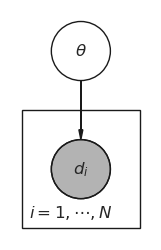

In [3]:
pgm = daft.PGM(grid_unit=3.0, node_unit=1.5)

pgm.add_node("theta", r"$\theta$", 0, 2)
pgm.add_node("d", r"$d_i$", 0, 1, observed=True)
pgm.add_plate([-0.5, 0.5, 1.0, 1.0], label=r"$i = 1, \cdots, N$")#, shift=-0.1

pgm.add_edge("theta", "d")

pgm.render(dpi=100);

In standard mathematical notation this would be:

$\displaystyle
\begin{array}{rcl}
p(\theta) &=& \mathrm{Beta}(\alpha=1,\beta=1) \\
p(X_i=d_i\,|\,\theta) &=& \mathrm{Bernoulli}(X_i=d_i;p=\theta) \\
\displaystyle p(X_1=d_1, X_2 = d_2, ..., X_n = d_n, \theta)&=& \displaystyle p(\theta) \cdot\prod_{i=1}^N p(X_i=d_i\,|\,\theta)
\end{array}
$

Where on the left hand side you have the total probability and on the right hand side you have the prior probability $p(\theta)$ (here given as a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)) multiplied by the [conditional probabilities](https://en.wikipedia.org/wiki/Conditional_probability) $p(X_i=d_i\,|\,\theta)$ (here given as a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)). The important point to remember is **YOU NEED THE TOTAL PROBABILITY FUNCTION**. How you get it does not matter. The tutal probability function is a scalar function, e.g. once you provide all arguments you get a scalar.

For pure continuous probability density functions and pure discrete probability mass functions this is straight forward. In the pure continuous case you in general have a function like a product of Gauss/Normal:
$f(x_1,x_2;\mu,\sigma)=\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{1}{2}\frac{(x_1-\mu)^2}{\sigma^2} }\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{1}{2}\frac{(x_2-\mu)^2}{\sigma^2} }$. In the pure discrete case you get a multi dimensional array like for two dice throws

In [4]:
A = sympy.ones(6,6)/36
A

Matrix([
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36],
[1/36, 1/36, 1/36, 1/36, 1/36, 1/36]])

For mixed cases I often got confused. Let's look at two examples.

### Examples of mixed discrete continuous probability functions

Below I am exaggerating the level of being explicite about each step and the level at which I use [sympy](https://www.sympy.org/en/index.html) to achieve this explicitness. I hope that this will help you from suffering a similar level of confusion that I found myself in. In addition you might learn to appreciate to use *sympy*, which is really great for symbolic algebra.

#### Two independent dice throws 

The first one is what we currently look at: independent dice throws. Let's look at two independent dice throws where we don't know $\theta\in[0,1]$: $p(d_1,d_2,\theta)=p(X_0=d_0\,|\,\theta)\cdot p(X_1=d_1\,|\,\theta)\cdot p(\theta)$. If we take $p(\theta)=\mathrm{Beta}(1,1)=1$ for $\theta\in[0,1]$ we get for each dice a one dimensional matrix with two entries:

In [5]:
stheta = sympy.var(r'\theta')
D1 = sympy.Matrix([[(1-stheta)], [stheta]])
D1

Matrix([
[1 - \theta],
[    \theta]])

Where the entry with index 0 is the case where we receive "tail" and where the entry with index 1 is the case where we receive "head". We can index into that vector:

In [6]:
display(D1[0]),display(D1[1]);

1 - \theta

\theta

For the second dice we take a 2x1 matrix, so that when we multiply the two we will get a 2x2 matrix for the 2x2 combinations of tail and head for each coin:

In [7]:
D2 = sympy.Matrix([[(1-stheta), stheta]])
D = D1*D2
D

Matrix([
[    (1 - \theta)**2, \theta*(1 - \theta)],
[\theta*(1 - \theta),           \theta**2]])

We said above that a probability function needs to be a function that takes as arguments the values of all random variables and delivers a scalar. In python this would look like:

In [8]:
def two_dice_roll_probability_function(theta, d1, d2):
    v = D.subs(stheta, theta)
    v = v[d1,d2] # we use indexing to access a concrete slot in the multi dimensional array
    return v

If we then wanted to know the probability of one head and one tail for a fair coin we would get:

In [9]:
theta = sympy.Integer(1)/2
display(theta)
two_dice_roll_probability_function(theta, 1, 0)

1/2

1/4

The other way we could have done it would be by the use of the [Kronecker_delta](https://en.wikipedia.org/wiki/Kronecker_delta) and using the fact that any number to the power of $0$ is $1$: $x^0=1$, e.g. the neutral element of our product of probability functions.

In [10]:
sd1, sd2 = sympy.symbols('d1:3') # we define two new sympy symbols for d1 and d2
sd1, sd2

(d1, d2)

Below the first $1$ is to remind us of the $p(\theta)=\mathrm{Beta}(1,1)=1$. In case that we used another prior this would be a different factor.

In [11]:
D_ = 1*(1-stheta)**sympy.KroneckerDelta(0,sd1)*stheta**sympy.KroneckerDelta(1,sd1)*(1-stheta)**sympy.KroneckerDelta(0,sd2)*stheta**sympy.KroneckerDelta(1,sd2)
D_

\theta**KroneckerDelta(1, d1)*\theta**KroneckerDelta(1, d2)*(1 - \theta)**KroneckerDelta(0, d1)*(1 - \theta)**KroneckerDelta(0, d2)

In [12]:
def two_dice_roll_probability_function_(theta, d1, d2):
    v = D_.subs(stheta, theta)
    v = v.subs(sd1,d1)
    v = v.subs(sd2,d2)
    return v

And of course you get the same result:

In [13]:
two_dice_roll_probability_function(theta, 1, 0)

1/4

The Kronecker delta variant looks more like a function, but a computer works better with an index lookup in a matrix. Finally we could use an **if-then-else** structure, but many probabilistic programming environments behave clumsy when it comes to if-then-else constructs.

#### Two component mixture model

The second example is a two component mixture model. In most cases people will show a mixture of two Gaussians, but with two Gaussians you can get away with using an array of $\mu$ and $\sigma$. Let's look at mixing one Gaussian with one Exponential distribution:

In [14]:
smu, sx = sympy.symbols(r'\mu x')
si = sympy.symbols('i', integer=True)
sp0, sp1 = sympy.symbols(r'p:2')
ssigma = sympy.Symbol("\sigma", positive=True)
slambda = sympy.Symbol("\lambda", positive=True)
sympy.Matrix([smu, ssigma, slambda, sx, si, sp0, sp1]).T # just for displaying the symbols

Matrix([[\mu, \sigma, \lambda, x, i, p0, p1]])

In [15]:
sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx)

sqrt(2)*exp(-(-\mu + x)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma)

In [16]:
sympy.stats.crv_types.ExponentialDistribution(slambda).pdf(sx)

\lambda*exp(-\lambda*x)

For the mixture to work we use a mixture indicator $i\in\{0,1\}$. If $i$ is 0 then we draw from the Exponential distribution and when $i$ is 1 we draw from the normal distribution. 

In [17]:
sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(sx)

Piecewise((p1, Eq(x, 1)), (1 - p1, Eq(x, 0)), (0, True))

In [18]:
print(sympy.latex(sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(sx)))

\begin{cases} p_{1} & \text{for}\: x = 1 \\1 - p_{1} & \text{for}\: x = 0 \\0 & \text{otherwise} \end{cases}


In [19]:
sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(1)

p1

In [20]:
sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(0)

1 - p1

$$p(p_1,i,\lambda,\mu,\sigma,x)=p(p_1)p(i\,|\,p_1)\begin{cases}p(\lambda)p(x\,|\,\lambda) & \text{for}\: i = 0\\ p(\mu)p(\sigma)p(x\,|\,\mu,\sigma) & \text{for}\: i = 1 \\0 & \text{otherwise} \end{cases}$$

In [21]:
sprior_exponential = sympy.stats.crv_types.ExponentialDistribution(1).pdf(slambda)
sprior_normal = sympy.stats.crv_types.ExponentialDistribution(1).pdf(ssigma)*sympy.stats.crv_types.NormalDistribution(0, 100).pdf(smu)
sprior_mixture_components = sprior_normal*sympy.stats.crv_types.BetaDistribution(1,1).pdf(sp1)
sprior = sprior_exponential*sprior_normal*sprior_mixture_components
smixture = sprior * \
    (sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(0)*sympy.stats.crv_types.ExponentialDistribution(slambda).pdf(sx))**sympy.KroneckerDelta(0,si) * \
    (sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(1)*sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx))**sympy.KroneckerDelta(1,si)
smixture 

(\lambda*(1 - p1)*exp(-\lambda*x))**KroneckerDelta(0, i)*(sqrt(2)*p1*exp(-(-\mu + x)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma))**KroneckerDelta(1, i)*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)/(20000*pi)

In [22]:
sympy.summation(smixture, (si, 0, 1))

(\lambda*(1 - p1)*exp(-\lambda*x) + sqrt(2)*p1*exp(-(-\mu + x)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma))*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)/(20000*pi)

In [23]:
M = sympy.Matrix([sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(0)*sympy.stats.crv_types.ExponentialDistribution(slambda).pdf(sx), sympy.stats.frv_types.BernoulliDistribution(sp1, 1, 0).pmf(1)*sympy.stats.crv_types.NormalDistribution(smu, ssigma).pdf(sx)])
sympy.UnevaluatedExpr(sympy.UnevaluatedExpr(sprior) * sympy.UnevaluatedExpr(M))

(exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)/(20000*pi))*Matrix([
[                                \lambda*(1 - p1)*exp(-\lambda*x)],
[sqrt(2)*p1*exp(-(-\mu + x)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma)]])

In [24]:
E = sprior * sympy.UnevaluatedExpr(M)
E

exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*Matrix([
[                                \lambda*(1 - p1)*exp(-\lambda*x)],
[sqrt(2)*p1*exp(-(-\mu + x)**2/(2*\sigma**2))/(2*sqrt(pi)*\sigma)]])/(20000*pi)

In [25]:
E_ = E.doit()

In [26]:
E_[0]

\lambda*(1 - p1)*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*exp(-\lambda*x)/(20000*pi)

In [27]:
E_[1]

sqrt(2)*p1*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*exp(-(-\mu + x)**2/(2*\sigma**2))/(40000*pi**(3/2)*\sigma)

In [28]:
sympy.Add(*[E_[i] for i in range(2)])

\lambda*(1 - p1)*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*exp(-\lambda*x)/(20000*pi) + sqrt(2)*p1*exp(-\lambda)*exp(-\mu**2/10000)*exp(-2*\sigma)*exp(-(-\mu + x)**2/(2*\sigma**2))/(40000*pi**(3/2)*\sigma)

In [29]:
sympy.simplify(sympy.summation(smixture, (si, 0, 1)) - sympy.Add(*[E_[i] for i in range(2)]))

0

In [30]:
samples = np.array([0,0,0,1,1,1,1,1,1])

with pm.Model() as model:
    theta = pm.Beta('theta', 1.0, 1.0)
    di = pm.Bernoulli('d', theta, observed=samples)
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
/home/local/cs/local/install/anaconda3-2021.05-Linux-x86_64/envs/py38ds/lib/python3.8/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


In [31]:
# pm.summary(trace)

In [32]:
# pm.plot_trace(trace)

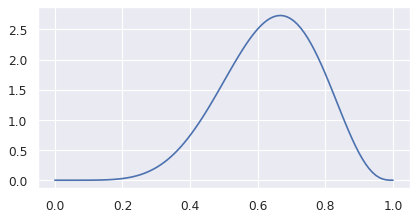

In [33]:
plt.figure(figsize=(6, 3), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1, 1, 1)
x = np.linspace(0.0,1.0,100)
y = stats.beta(1+6,1+3).pdf(x)
ax.plot(x,y);